In [1]:
import os
os.add_dll_directory("C:\\Users\\33631\\Desktop\\openslide-win64-20171122\\bin")

import openslide

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import openslide
import random
import cv2
import matplotlib
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
import re

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torchvision.models as models
import torchvision
import torch
import torch.nn as nn
from torch.optim import Adam
from torch import LongTensor as LongTensor
from torch import FloatTensor as FloatTensor
import pickle

c:\Users\33631\Documents\Etudes\centrale 3A\Deep Learning for medical Imaging\prostate_cancer_detection\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\33631\Documents\Etudes\centrale 3A\Deep Learning for medical Imaging\prostate_cancer_detection\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
train_set_path = "Data/raw_data/train.csv"
test_set_path = "Data/raw_data/test.csv"
test_images_folder = "Data/raw_data/test/test/"
train_images_folder = "Data/raw_data/train/train/"
train_mask_folder = "Data/raw_data/train_label_masks/train_label_masks/"
train_tiles_random_folder = "Data/processed_data/tiles_train_random/"
train_tiles_folder = "Data/processed_data/train_tiles/"
test_tiles_folder = "Data/processed_data/test_tiles/"
train_tiles_folder_encoding = "Data/processed_data/train_tiles_encoding/"
test_tiles_folder_encoding = "Data/processed_data/test_tiles_encoding/"

### Road Map:

we will predict the gleason scores and then convert it to isup grade

## Usefull stuff

In [4]:
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

## Load data and explore data

In [5]:
train_set = pd.read_csv(train_set_path)
test_set = pd.read_csv(test_set_path)

In [6]:
# let's check the correspondance between isup and gleason
(train_set[['isup_grade','gleason_score']]
    .groupby('isup_grade')
    .agg({'gleason_score': lambda x: x.unique()})
)

,gleason_score
isup_grade,
0,"[negative, 0+0]"
1,[3+3]
2,[3+4]
3,[4+3]
4,"[4+4, 3+5, 5+3]"
5,"[5+4, 4+5, 5+5]"


In [7]:
# count isup grades
(train_set[['isup_grade','gleason_score']]
    .groupby('isup_grade')
    .count()
)

,gleason_score
isup_grade,
0,85
1,85
2,37
3,45
4,42
5,46


In [8]:
# image provider
(train_set[['data_provider','gleason_score']]
    .groupby('data_provider')
    .count()
)

,gleason_score
data_provider,
karolinska,194
radboud,146


## Visualisations

In [9]:
def visualise_mask_and_image(id, level = 3): # last level by default
    line = train_set.iloc[id]

    data_provider = line.data_provider
    isup_grade = line.isup_grade
    gleason_score = line.gleason_score
    image_id = line.image_id

    image = openslide.OpenSlide(train_images_folder+image_id+'.tiff')
    print(image.level_dimensions)
    image_data = image.read_region((0,0), image.level_count - 1, image.level_dimensions[-1])
    try:
        mask = openslide.OpenSlide(train_mask_folder+image_id+'.tiff')
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
    except:
        print('no mask for this image')
        mask = None
        mask_data = None


    fig, axes = plt.subplots(1,2, figsize=(8,8))
    axes[0].imshow(image_data)
    axes[1].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)

    title = f"gleason score: {gleason_score} - isup grade: {isup_grade} \n data provider: {data_provider}"
    fig.suptitle(title, fontsize=14)
    
    mask.close()
    image.close()
    fig.tight_layout()
    plt.show()


((23040, 8704), (5760, 2176), (1440, 544))


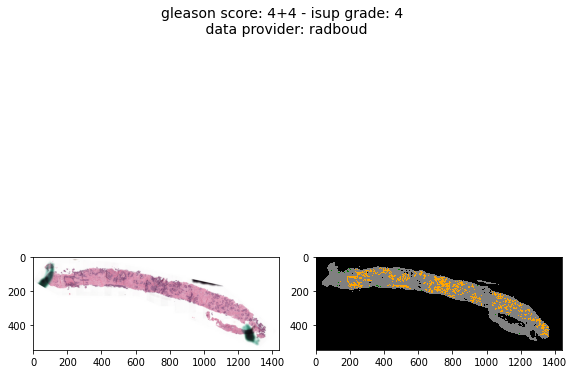

In [10]:
visualise_mask_and_image(1)

((7168, 24576), (1792, 6144), (448, 1536))


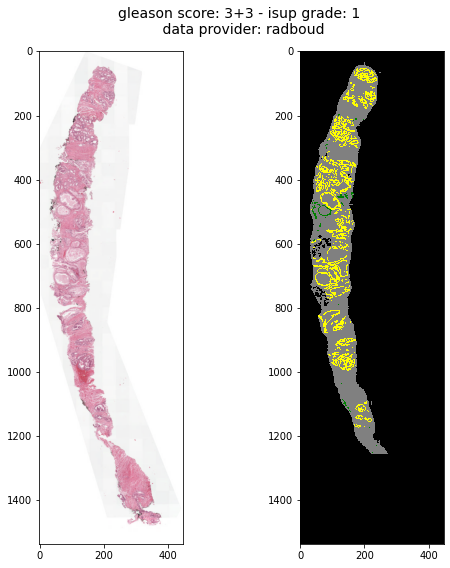

In [11]:
visualise_mask_and_image(2)

((22528, 29952), (5632, 7488), (1408, 1872))


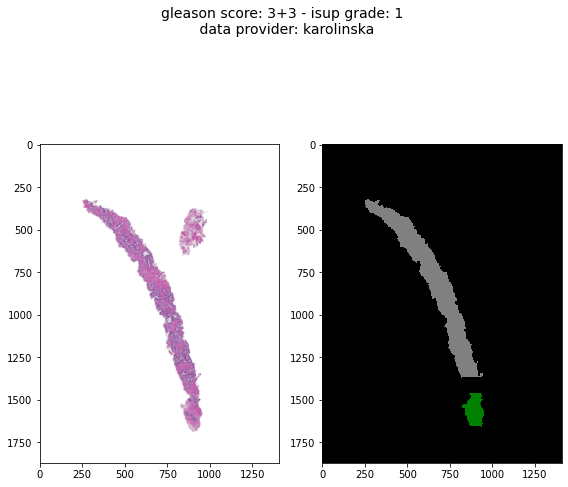

In [12]:
visualise_mask_and_image(15)

# Tiling functions

In [13]:
from histolab.tiler import RandomTiler, GridTiler
from histolab.slide import Slide

In [14]:
def create_tiles(df, folder_dest, folder_source, tile_shape = 224, level = 1, n_tiles = 128):
    for i in tqdm(range(df.shape[0]), position = 0):
        value = df.iloc[i]
        id = value.image_id
        if os.path.isdir(folder_dest+f"{id}/"):
            continue
        image = Slide(folder_source+id+".tiff", processed_path=folder_dest)

        random_tiles_extractor = RandomTiler(
                    tile_size=(tile_shape,tile_shape),
                    level=level,
                    n_tiles=n_tiles,
                    seed=42,
                    check_tissue=True, # default
                    tissue_percent=80.0, # default
                    prefix=f'{id}/', # save tiles in the "random" subdirectory of slide's processed_path
                    suffix=".png" # default
                )
        random_tiles_extractor.extract(image)

## Tiles encoding functions

In [15]:
def extract_tiles_coords(img_name):
    """
    extract tile coordinate from the file name
    """
    exp = '([0-9]*)-([0-9]*)-([0-9]*)-([0-9]*).png$'
    match = re.search(exp, img_name)
    x_ul_wsi = match[1]
    y_ul_wsi = match[2]
    x_br_wsi = match[3]
    y_br_wsi = match[4]
    return(int(x_ul_wsi),int(y_ul_wsi), int(x_br_wsi),int(y_br_wsi))

In [29]:
# define encoder model
encoder = models.efficientnet_b1(pretrained=True)
encoder = nn.Sequential(*list(encoder.children()))[:-1].eval().to("cuda")

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to C:\Users\33631/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-533bc792.pth
100%|██████████| 30.1M/30.1M [00:10<00:00, 3.10MB/s]


In [30]:
def encode_tiles(df, source_dir, dest_dir, encoder):
    for i in tqdm(range(df.shape[0]), position = 0):
        value = df.iloc[i]
        image_id = value.image_id
        if os.path.isdir(dest_dir+f'{image_id}.pkl'):
            continue
        # compute file
        image_folder = source_dir+image_id+'/'
        # pick images to put in the bag randomly
        tiles_list = np.array(os.listdir(image_folder))
        encoding_dict = {}
        for img_name in tiles_list:
            img_path = image_folder+img_name
            x_ul_wsi,y_ul_wsi, x_br_wsi,y_br_wsi = extract_tiles_coords(img_name)
            # get image
            tile_image = np.array(Image.open(img_path))
            # convert to RGB
            tile_image = Image.fromarray(tile_image)
            tile_image = tile_image.convert('RGB')
            # to 0/1 range
            tile_image = torchvision.transforms.functional.to_tensor(tile_image) # to 0/1 range and permute 

            normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            tile_image = normalize(tile_image).unsqueeze(0).to("cuda")
            # get encoding
            encoding = encoder(tile_image).squeeze(-1).squeeze(-1)[0].cpu().detach().numpy()
            # add to dict
            encoding_dict[(x_ul_wsi,y_ul_wsi, x_br_wsi,y_br_wsi)] = encoding
        pickle.dump(encoding_dict, open(dest_dir+f'{image_id}.pkl', 'wb'))

## Compute and encode tiles

In [ ]:
# params

tiles_shape  = 224
level = 0
n_tiles = 200

For the train set

In [19]:
create_tiles(train_set, folder_dest = train_tiles_folder, folder_source=train_images_folder , tile_shape = tiles_shape, level = level, n_tiles = n_tiles)

100%|██████████| 340/340 [1:53:08<00:00, 19.97s/it]  


In [31]:
encode_tiles(train_set, source_dir = train_tiles_folder, dest_dir = train_tiles_folder_encoding, encoder = encoder)

100%|██████████| 340/340 [53:47<00:00,  9.49s/it]


For the test set

In [32]:
# for test set
create_tiles(test_set, folder_dest = test_tiles_folder, folder_source=test_images_folder , tile_shape = tiles_shape, level = level, n_tiles = n_tiles)

100%|██████████| 86/86 [25:46<00:00, 17.99s/it]


In [33]:
# for train set
encode_tiles(test_set, source_dir = test_tiles_folder, dest_dir = test_tiles_folder_encoding, encoder = encoder)


100%|██████████| 86/86 [13:42<00:00,  9.57s/it]
